## Open Information Extraction
Open information extraction (open IE) refers to the extraction of relation tuples, typically binary relations, from plain text, such as (Mark Zuckerberg; founded; Facebook). The central difference from other information extraction is that the schema for these relations does not need to be specified in advance; typically the relation name is just the text linking two arguments.
- StanfordOpenIE (https://nlp.stanford.edu/software/openie.html) StanfordOpenIE is part of StanfordCoreNLP, which is built on top of PyTorch 1.0.0. 
 - Therefore, first install pytorch (https://pytorch.org/get-started/locally/), select your  os, package, language, cuda , then use the   command to install.
 - Install StanfordOpenIE using ``pip install stanford-openie``(https://pypi.org/project/stanford-openie/)

In [1]:
import nltk
from nltk import pos_tag, word_tokenize, ne_chunk, Tree
from openie import StanfordOpenIE
from graphviz import Digraph

### Triple Extraction from text using ``StanfordOpenIE``

In [2]:
# Example code for using StanfordOpenIE in python
from openie import StanfordOpenIE

with StanfordOpenIE() as client:
    text = 'Barack Obama was the 44th president of the United States'
    print('Text: %s.' % text)
    for triple in client.annotate(text):
        print('|-', triple)

Text: Barack Obama was the 44th president of the United States.
Starting server with command: java -Xmx8G -cp C:\Users\UIC\stanfordnlp_resources\stanford-corenlp-full-2018-10-05/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-1b771d0d66274c7f.props -preload openie
|- {'subject': 'Barack Obama', 'relation': 'was 44th president of', 'object': 'United States'}
|- {'subject': 'Barack Obama', 'relation': 'was president of', 'object': 'United States'}
|- {'subject': 'Barack Obama', 'relation': 'was', 'object': 'president'}
|- {'subject': 'Barack Obama', 'relation': 'was', 'object': '44th president'}


For each sentence, StanfordOpenIE will return several triples with high confidence scores. To further refine the results, we can perform filtering by some constraints:
- The subjet and object must be named entity from some predfined types
- The relation must be verb or verb phrases (chunk rule)

Come up with your own refinement strategy to get a better result.

In [3]:

def get_chunks(text):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    ents = []
    for i in chunked:
        if type(i) == Tree:
            label = i.label()
            ent = " ".join([token for token, pos in i.leaves()])
            ents.append(ent)
    return ents

def extract_triple(text):
    triples = []
    ne = get_chunks(text)
    with StanfordOpenIE() as client:
        print('Text: %s.' % text)
        for triple in client.annotate(text):
            if triple['subject'] in ne and triple['object'] in ne:
                triples.append([triple['subject'], triple['relation'],  triple['object']])
    
    return triples


tr = extract_triple(""" Barack Obama was the 44th president of the United States, and the first African American to serve in the office.
          On October 3, 1992,  Barack Obama married  Michelle Robinson at Trinity United Church in Chicago. """)
print("Extracted Triples:",tr)

Text:  Barack Obama was the 44th president of the United States, and the first African American to serve in the office.
          On October 3, 1992,  Barack Obama married  Michelle Robinson at Trinity United Church in Chicago. .
Starting server with command: java -Xmx8G -cp C:\Users\UIC\stanfordnlp_resources\stanford-corenlp-full-2018-10-05/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-220dca3bc8984afa.props -preload openie
Extracted Triples: [['Barack Obama', 'was 44th president of', 'United States'], ['Barack Obama', 'was president of', 'United States'], ['Barack Obama', 'married', 'Michelle Robinson'], ['Barack Obama', 'married Michelle Robinson at', 'Trinity United Church'], ['Barack Obama', 'married Michelle Robinson in', 'Chicago']]


### Construct the KB from Triples
- Get the entity set and relation set

In [4]:
def KB(triples):
    dot = Digraph(comment='Knowledge Graph Demo')
    ent = []
    rel = []
    for triple in triples:
        sub = triple[0]
        re = triple[1]
        ob = triple[2]
        ent.append(sub)
        ent.append(ob)
        rel.append(re)
    
    en_id = {}
    re_id = {}
    triples_id = []
    eid = 0
    rid = 0
    id_en = dict(zip(range(len(set(ent))),set(ent)))
    en_id = dict(zip(set(ent), range(len(set(ent)))))
    id_re = dict(zip(range(len(set(rel))),set(rel)))
    re_id = dict(zip(set(rel), range(len(set(rel)))))
    
    for triple in triples:
        sub = triple[0]
        re = triple[1]
        ob = triple[2]
        triples_id.append([en_id[sub],re_id[re],en_id[ob]])
    return id_en,id_re,triples_id

kb = KB(tr)
print("Entities:", kb[0], "\nRelations:",kb[1], "\nTriples:",kb[2])

Entities: {0: 'Michelle Robinson', 1: 'United States', 2: 'Barack Obama', 3: 'Chicago', 4: 'Trinity United Church'} 
Relations: {0: 'married', 1: 'was 44th president of', 2: 'married Michelle Robinson in', 3: 'married Michelle Robinson at', 4: 'was president of'} 
Triples: [[2, 1, 1], [2, 4, 1], [2, 0, 0], [2, 3, 4], [2, 2, 3]]


### Visualize the KB using ``graphviz``
- To render the graph, the dependency is a working installation of ``Graphviz`` (https://www.graphviz.org/download/).
- After installing Graphviz, make sure that its ``bin/`` subdirectory containing the layout commands for rendering graph descriptions (dot, circo, neato, etc.) is on your systems’ path: On the command-line, ``dot -V`` should print the version of your Graphiz installation.

In [5]:
def visualizeKB(kb_input):
    id_en = kb_input[0]
    id_re = kb_input[1]
    triples_id = kb_input[2]
    dot = Digraph(comment='KB-Demo')
    for eid,en in id_en.items():
#         print(eid,en)
        dot.node("{0}".format(eid),en)
    for triple in triples_id:
#         print(triple[0],triple[1],triple[2])
        dot.edge("{0}".format(triple[0]),"{0}".format(triple[2]),"{0}".format(id_re[triple[1]]))
    return dot
dot = visualizeKB(kb)
print(dot.source)

// KB-Demo
digraph {
	0 [label="Michelle Robinson"]
	1 [label="United States"]
	2 [label="Barack Obama"]
	3 [label=Chicago]
	4 [label="Trinity United Church"]
	2 -> 1 [label="was 44th president of"]
	2 -> 1 [label="was president of"]
	2 -> 0 [label=married]
	2 -> 4 [label="married Michelle Robinson at"]
	2 -> 3 [label="married Michelle Robinson in"]
}


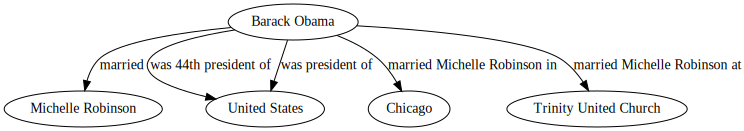

In [6]:
dot.render('kb-demo', view=True) 
dot